# Catena completa

## Importo librerie e costanti

In [12]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import math

In [13]:
# distribuzione uniforme
deltaTosigma= 0.58
# multimetro 
multi_C_dig = 5*deltaTosigma # errore digit capacità
multi_C_k = 0.03*deltaTosigma # errore scala capacità

multi_R_dig = 2*deltaTosigma # errore digit resistenza
multi_R_k = 0.008*deltaTosigma # errore scala resistenza

# oscilloscopio (tensioni)
osc_scala = 0.03*deltaTosigma
osc_dig = 2/256*deltaTosigma

# oscilloscopio (tempi)
# trascurabile?
osc_t_err=0.04 # errore lettura, [div]

In [14]:
def getOscErr(x,scala):
    return ((osc_scala*x)**2+(osc_dig*scala)**2)**0.5

## Misure dirette dei componenti

In [15]:
R1a=32.8 # kOhm
R1a_e=( (multi_R_k*R1a)**2+(multi_R_dig*0.1)**2 )**0.5
R2a1=67.9 # kOhm
R2a1_e=( (multi_R_k*R2a1)**2+(multi_R_dig*0.1)**2 )**0.5
R2a2=120.6 # kOhm
R2a2_e=( (multi_R_k*R2a2)**2+(multi_R_dig*0.1)**2 )**0.5
R2a = R2a1+R2a2
R2a_e = (R2a1_e**2+R2a2_e**2)**0.5
print(R1a,R1a_e)
print(R2a1,R2a1_e)
print(R2a2,R2a2_e)
print(R2a,R2a_e)

32.8 0.1913593605340486
67.9 0.3357324576742618
120.6 0.5714807547555736
188.5 0.6628020339377362


Voglio ottenere $V_{out}=2\,V$ quindi registro il max e poi calcolo valori resistenze richiesti

In [16]:
# vmax
vmax=0.29 # volt
vmax_e=getOscErr(vmax,0.5) # volt
print("vmax",vmax,vmax_e)

# Amplificazione richiesta
Ampli=2.0/vmax

# rapporto Ra2/Ra1
print("Ra2/Ra1", Ampli-1)
print("Ampli", Ampli)

vmax 0.29 0.005531290323299347
Ra2/Ra1 5.8965517241379315
Ampli 6.8965517241379315


Confronto coi valori scelti

In [17]:
Hth=(R2a1+R2a2)/R1a+1
Hth_e=Hth*((R2a1_e/R2a1)**2+
          (R2a2_e/R2a2)**2+
          (R1a_e/R1a)**2)**0.5
compH=(Hth-Ampli)/(Hth_e)
print(compH, Hth)

-2.464585219578231 6.746951219512195


## Stadio finale di amplificazione

Per verificare il corretto funzionamento del circuito,
viene inserito in ingresso un segnale sinusoidale di frequenza $1\,kHz$ e ampiezza $1V$.

L'amplificazione teorica è data da $H_{th}=\frac{R_{2a1}+R_{2a2}}{R_{1a}}+1$

In [18]:
Hth=(R2a1+R2a2)/R1a+1
Hth_e=Hth*((R2a1_e/R2a1)**2+
          (R2a2_e/R2a2)**2+
          (R1a_e/R1a)**2)**0.5
print(Hth,Hth_e)

6.746951219512195 0.06070007376386752


Sperimentalmente invece si osserva

In [19]:
Vin=0.985
Vin_scala=2
Vout_scala=10
Vout=6.672
Vout_e=((osc_dig*Vout_scala)**2+(osc_scala*Vout)**2)**0.5
Vout_e = getOscErr(Vout,Vout_scala)
Vin_e=((osc_dig*Vin_scala)**2+(osc_scala*Vin)**2)**0.5
Hsp=Vout/Vin
Hsp_e=Hsp*((Vout_e/Vout)**2+(Vin_e/Vin)**2)**0.5
print(Vin,Vin_e)
print(Vout,Vout_e)
print(Hsp,Hsp_e)

0.985 0.019387476041248897
6.672 0.12462247336692527
6.773604060913706 0.18379984873944924


La compatibilità vale quindi:

In [20]:
comp=abs(Hth-Hsp)/(Hth_e**2+Hsp_e**2)**0.5
print(comp)

0.13769549477598242


Si inserisce ora il segnale dello shaper in input e 
si verifica di ottenere l'oputput previsto

In [21]:
Vin=-0.995 # V
Vin_scala=2
Vout=2.08 # V
Vout_scala=5
Vin_e=((osc_dig*Vin_scala)**2+(osc_scala*Vin)**2)**0.5
Vout_e=((osc_dig*Vout_scala)**2+(osc_scala*Vout)**2)**0.5
Hsp=Vout/Vin
Hsp_e=abs(Hsp)*((Vout_e/Vout)**2+(Vin_e/Vin)**2)**0.5
print(Vin,Vin_e)
print(Vout,Vout_e)
print(Hsp,Hsp_e)
comp=abs(Vout-2)/Vout_e
print(comp)

-0.995 0.019541465534856896
2.08 0.04269855416829123
-2.090452261306533 0.05938950156523968
1.873599740279019


## Linearità della catena elettronica

Si modifica ora la durata dell'impulso di ingresso in modo 
da variare al quantità di carica iniettata e si misura
l'altezza massima del segnale in uscita.
Importo i le coppie $V_{out}^{MAX}$,$Q_{IN}$.

In [22]:
data_lin=pd.read_csv("dati/tot_lin.txt",delimiter="\t")
# [Volt], [us]

# capacità
Cf_pre = 0.189 # nF
Cf_pre_err=((0.001*multi_C_dig)**2 
           + (Cf_pre*multi_C_k)**2)**0.5

# resistenze
Rf_pre = 0.816 # MOhm
Rf_pre_err=((0.001*multi_R_dig)**2 
           + (Rf_pre*multi_R_k)**2)**0.5
Rin = 82.0 #kOhm
Rin_err = ((0.1*multi_R_dig)**2+
          (Rin*multi_R_k)**2)**0.5
# generatore
Rgen = 600 # Ohm
#Rin=Rin+Rgen*10**(-3)
print("Cf_pre (nF)", Cf_pre, Cf_pre_err,Cf_pre_err/Cf_pre*100)
print("Rf_pre (MOhm)", Rf_pre, Rf_pre_err, Rf_pre_err/Rf_pre*100)
print("Rin (kOhm)", Rin, Rin_err, Rin_err/Rin*100)

Cf_pre (nF) 0.189 0.004384619705288019 2.319904605972497
Rf_pre (MOhm) 0.816 0.003959951178688949 0.48528813464325354
Rin (kOhm) 82.0 0.397770072277943 0.4850854539974915


Calcolo le cariche dai periodi, ma per il momento
ignoro l'errore (correlazione)

In [118]:
data_lin['Q']=-data_lin['T']/Rin*data_lin['vin']
data_lin

,vin,vout,scala,T,Q,vout_e
0,-0.995,0.8336,1,5,0.060671,0.015196
1,-0.995,0.9201,1,6,0.072805,0.016639
2,-0.995,1.0950,2,7,0.084939,0.021098
3,-0.995,1.1810,2,8,0.097073,0.022459
4,-0.995,1.4440,2,10,0.121341,0.026710
5,-0.995,1.6910,2,12,0.145610,0.030787
6,-0.995,1.8500,2,13,0.157744,0.033441
7,-0.995,2.0720,5,15,0.182012,0.042581


Associo gli errori delle y

In [119]:
data_lin['vout_e']=((osc_dig*data_lin['scala'])**2+
                    (osc_scala*data_lin['vout'])**2)**0.5
data_lin

,vin,vout,scala,T,Q,vout_e
0,-0.995,0.8336,1,5,0.060671,0.015196
1,-0.995,0.9201,1,6,0.072805,0.016639
2,-0.995,1.0950,2,7,0.084939,0.021098
3,-0.995,1.1810,2,8,0.097073,0.022459
4,-0.995,1.4440,2,10,0.121341,0.026710
5,-0.995,1.6910,2,12,0.145610,0.030787
6,-0.995,1.8500,2,13,0.157744,0.033441
7,-0.995,2.0720,5,15,0.182012,0.042581


Faccio grafico + fit

[10.35311626  0.19149056]
0.23366303794060392 0.022834262687171286
0.019945521169099138 5.5855738688502194


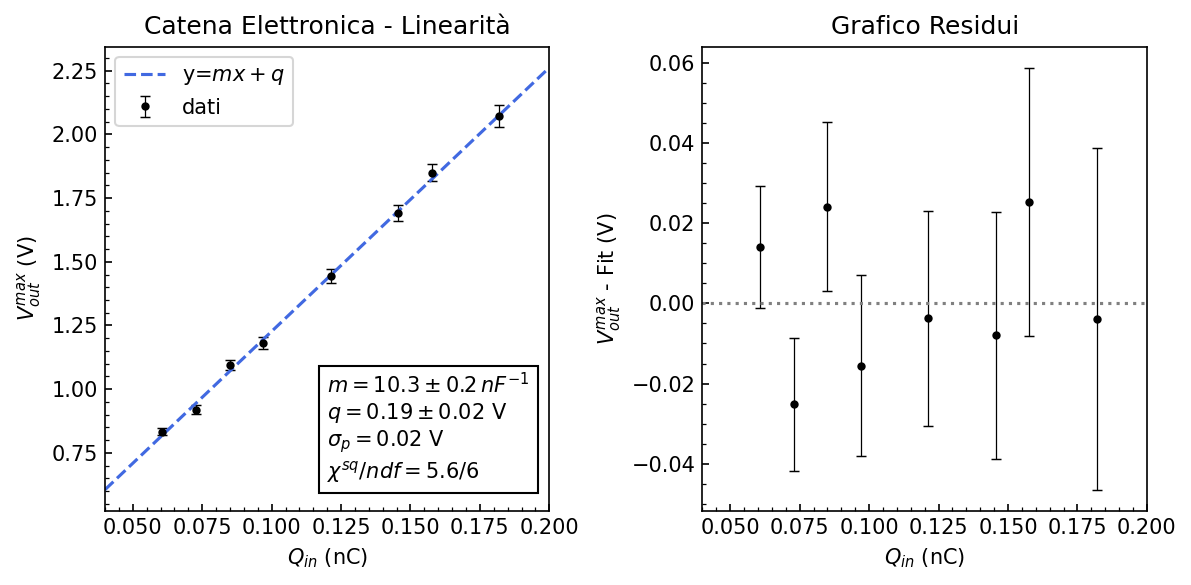

In [128]:
X=data_lin['Q']
Y=data_lin['vout']
Y_e=data_lin['vout_e']
xmin=0.04
xmax=0.2
fig,axes=plt.subplots(ncols=2,figsize=(8,4))
fig.set_dpi(150)
axes[0].errorbar(X,Y,Y_e,fmt='.',color='black', capsize=2.5,
                 capthick=0.7, elinewidth=0.6,label='dati')

def linF(X,m,q):
    return X*m+q

par,cov=curve_fit(linF,X,Y,sigma=Y_e,absolute_sigma=True)
axes[0].plot(np.linspace(xmin,xmax),linF(np.linspace(xmin,xmax),*par),
             "--",color='royalblue',label='y=$mx+q$')

diff=Y-linF(X,*par)
axes[1].errorbar(X,diff,Y_e,fmt='.',color='black', capsize=2.5,
                 capthick=0.7, elinewidth=0.6)

axes[1].plot(np.linspace(xmin,xmax),np.linspace(0,0),':',color='gray')

# chisq e sigma post
sigmap = (np.sum(diff**2)/(len(diff)-2))**0.5
chisq = np.sum(diff**2/Y_e**2)

# plot customiz
for i in axes:
    i.tick_params(axis='both', which='minor', direction='in')
    i.tick_params(axis='both', which='major', direction='in')
    i.minorticks_on()
axes[0].set_xlabel("$Q_{in}$ (nC)")
axes[1].set_xlabel("$Q_{in}$ (nC)")
axes[1].set_ylabel("$V_{out}^{max}$ - Fit (V)")
axes[0].set_ylabel("$V_{out}^{max}$ (V)")
axes[0].set_title("Catena Elettronica - Linearità")
axes[1].set_title("Grafico Residui")

axes[1].set_xlim(xmin,xmax)
axes[0].set_xlim(xmin,xmax)
axes[0].legend()

# box
axes[0].text(0.12,0.65, '$m=10.3\pm 0.2\, nF^{-1}$'
                               '\n$q=0.19 \pm 0.02$ V'
                                '\n$\sigma_p=0.02$ V'
                                '\n$\chi^{sq}/ndf=5.6/6$', color='black', 
       bbox=dict(facecolor='none', edgecolor='black', pad=4))


fig.tight_layout()
fig.savefig("../../latex/ampli/images/fit_lin.png", dpi=150)
print(par)
print(cov[0][0]**0.5, cov[1][1]**0.5)
print(sigmap,chisq)

## Risposta in frequenza della catena elettronica

Importo i dati 

,f,V
0,10.000000,12.098638
1,12.589254,12.098654
2,15.848932,12.098680
3,19.952623,12.098720
4,25.118864,12.098784
5,31.622777,12.098886
6,39.810717,12.099048
7,50.118723,12.099303
8,63.095734,12.099706
9,79.432823,12.100343


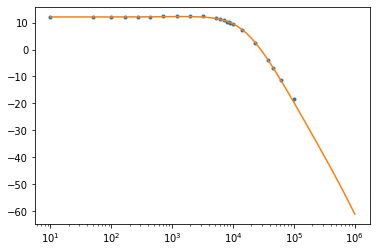

In [84]:
bode_data=pd.read_csv("dati/tot_bode.txt",delimiter="\t")
bode_sim=pd.read_csv("simulazioni/catena_bode1.txt",delimiter="\t")
bode_data['Vin_e']=osc_dig*bode_data['Vin_scala']
bode_data['Vout_e']=osc_dig*bode_data['Vout_scala']

# freq [Hz] V [Volt]
bode_data['Hdb']=20*np.log10(bode_data['Vout']/bode_data['Vin'])
X=bode_data['f']
Y=bode_data['Hdb']
plt.plot(X,Y,'.')
plt.plot(bode_sim['f'],bode_sim['V'])
plt.semilogx(True)
bode_sim

In [86]:
bode_data['Hdb_e']=20*( (bode_data['Vout_e']/bode_data['Vout'])**2+
                        (bode_data['Vin_e']/bode_data['Vin'])**2)**0.5*np.log10(math.e)
# dati a sx
inf1=0
sup1=5e3
X1=bode_data['f'][bode_data['f']<sup1][bode_data['f']>inf1]
Y1=bode_data['Hdb'][bode_data['f']<sup1][bode_data['f']>inf1]
Y1_e=bode_data['Hdb_e'][bode_data['f']<sup1][bode_data['f']>inf1]


# dati a dx
inf2=2.5e4
sup2=2e5
X2=bode_data['f'][bode_data['f']<sup2][bode_data['f']>inf2]
Y2=bode_data['Hdb'][bode_data['f']<sup2][bode_data['f']>inf2]
Y2_e=bode_data['Hdb_e'][bode_data['f']<sup2][bode_data['f']>inf2]
bode_data

,f,Vin,Vin_scala,Vout,Vout_scala,Vin_e,Vout_e,Hdb,Hdb_e
0,10,0.9850,2,3.9680,5.0,0.009062,0.022656,12.102709,0.094053
1,50,0.9850,2,3.9680,5.0,0.009062,0.022656,12.102709,0.094053
2,100,0.9850,2,3.9680,5.0,0.009062,0.022656,12.102709,0.094053
3,165,0.9850,2,3.9680,5.0,0.009062,0.022656,12.102709,0.094053
4,270,0.9850,2,4.0020,5.0,0.009062,0.022656,12.176817,0.093831
5,440,0.9850,2,4.0180,5.0,0.009062,0.022656,12.211474,0.093729
6,720,0.9850,2,4.0520,5.0,0.009062,0.022656,12.284664,0.093515
7,1180,0.9850,2,4.0520,5.0,0.009062,0.022656,12.284664,0.093515
8,1930,0.9850,2,4.0520,5.0,0.009062,0.022656,12.284664,0.093515
9,3160,0.9850,2,4.0520,5.0,0.009062,0.022656,12.284664,0.093515


par1 [ 0.10012884 11.94648851] par2 [-33.96925146 151.35120739]
m1 err 0.0407189434219221 q1 err 0.10501027174788466 m2 err 0.4571246086182585 q2 err 2.14606033764352
chi1 1.5498705802152066 chi2 1.507575289295951
sigmap1 0.041328597379099254 sigmap2 0.04668549814950922
cov1 -0.004101844822261292 cov2 -0.9806804286612221


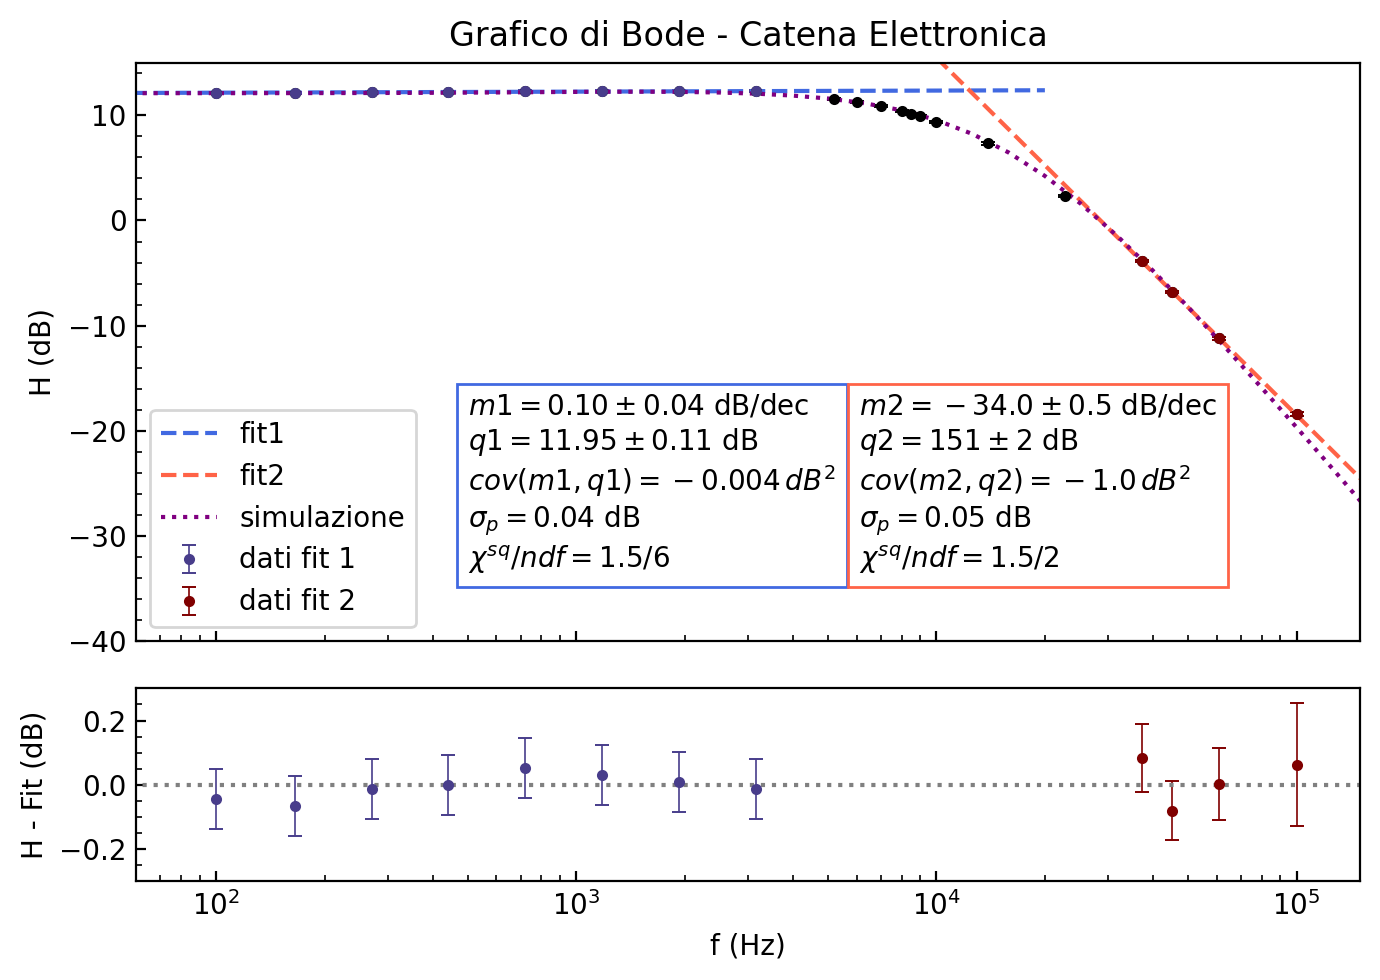

In [129]:
# fit
par1,cov1=curve_fit(linF,np.log10(X1),Y1, sigma=Y1_e, absolute_sigma=True)
par2,cov2=curve_fit(linF,np.log10(X2),Y2, sigma=Y2_e, absolute_sigma=True)

# plot fit+dati
fig,axes=plt.subplots(nrows=2, figsize=(7,5),gridspec_kw=dict(height_ratios=[3,1]),sharex=True)
fig.set_dpi(200)

axes[0].errorbar(bode_data['f'],bode_data['Hdb'], bode_data['Hdb_e'], fmt='.',color='black', capsize=2.5,
                 capthick=0.7, elinewidth=0.6)
axes[0].errorbar(X1,Y1,Y1_e, fmt='.',color='darkslateblue', capsize=2.5,
                 capthick=0.7, elinewidth=0.6,label='dati fit 1')
axes[0].errorbar(X2,Y2,Y2_e, fmt='.',color='maroon', capsize=2.5,
                 capthick=0.7, elinewidth=0.6,label='dati fit 2')
axes[0].plot(np.linspace(10,2e4),linF(np.log10(np.linspace(10,2e4)),*par1),'--', color='royalblue',label='fit1')
axes[0].plot(np.linspace(1e4,1e6),linF(np.log10(np.linspace(1e4,1e6)),*par2),'--',color='tomato',label='fit2')
axes[0].semilogx(True)

# plot simulazione
axes[0].plot(bode_sim['f'],bode_sim['V'],':',color='purple',label='simulazione')

# plot residui
diff1=Y1-linF(np.log10(X1),*par1)
diff2=Y2-linF(np.log10(X2),*par2)
axes[1].errorbar(X1,diff1,Y1_e,fmt='.',color='darkslateblue', capsize=2.5,
                 capthick=0.7, elinewidth=0.6)
axes[1].errorbar(X2,diff2,Y2_e,fmt='.',color='maroon', capsize=2.5,
                 capthick=0.7, elinewidth=0.6)
axes[1].plot(np.logspace(0,6),np.linspace(0,0),':',color='gray')

# chisq e sigma post
sigmap1 = (np.sum(diff1**2)/(len(diff1)-2))**0.5
chisq1 = np.sum(diff1**2/Y1_e**2)
sigmap2 = (np.sum(diff2**2)/(len(diff1)-2))**0.5
chisq2 = np.sum(diff2**2/Y2_e**2)


# plot customiz
axes[0].set_xlim(60,1.5e5)
axes[1].set_ylim(-0.3,0.3)
axes[0].set_ylim(-40,15)

axes[1].semilogx(True)
for i in axes:
    i.tick_params(axis='both', which='minor', direction='in')
    i.tick_params(axis='both', which='major', direction='in')
    i.minorticks_on()
axes[1].set_xlabel("f (Hz)")
axes[1].set_ylabel("H - Fit (dB)")
axes[0].set_ylabel("H (dB)")
axes[0].set_title("Grafico di Bode - Catena Elettronica")
axes[0].legend()
# box
axes[0].text(500,-33, '$m1=0.10\pm 0.04$ dB/dec'
                               '\n$q1=11.95 \pm 0.11$ dB'
                               '\n$cov(m1,q1)=-0.004\,dB^2$'
                                '\n$\sigma_p=0.04$ dB'
                                '\n$\chi^{sq}/ndf=1.5/6$', color='black', 
       bbox=dict(facecolor='none', edgecolor='royalblue', pad=4))

axes[0].text(6100,-33, '$m2=-34.0\pm 0.5$ dB/dec'
                               '\n$q2=151 \pm 2$ dB'
                               '\n$cov(m2,q2)=-1.0\,dB^2$'
                                '\n$\sigma_p=0.05$ dB'
                                '\n$\chi^{sq}/ndf=1.5/2$', color='black', 
       bbox=dict(facecolor='none', edgecolor='tomato', pad=4))


fig.tight_layout()
fig.savefig("../../latex/ampli/images/fit_bode.png", dpi=150)
print("par1",par1,"par2",par2)
print("m1 err",cov1[0][0]**0.5,"q1 err",cov1[1][1]**0.5,"m2 err",cov2[0][0]**0.5, "q2 err",cov2[1][1]**0.5)
print("chi1",chisq1,"chi2",chisq2)
print("sigmap1",sigmap1,"sigmap2",sigmap2)
print("cov1",cov1[1][0],"cov2",cov2[1][0])

In [88]:
m1=par1[0]
m1_e=cov1[0][0]**0.5
q1=par1[1]
q1_e=cov1[1][1]**0.5
m2=par2[0]
m2_e=cov2[0][0]**0.5
q2=par2[1]
q2_e=cov2[1][1]**0.5
covmq1=cov1[0][1]
covmq2=cov2[1][0]


ft_fit=(q1-q2)/(m2-m1)
ft_fit_e=ft_fit*( (q1_e**2+q2_e**2)/(q1-q2)**2 +
                  (m1_e**2+m2_e**2)/(m1-m2)**2 +
                  2*(covmq1+covmq2)/((q1-q2)*(m2-m1)) )**0.5

ft_fit_lin=10**ft_fit
ft_fit_lin_e=ft_fit_lin*np.log(10)*ft_fit_e

print(ft_fit_lin,ft_fit_lin_e)

12353.473797217745 241.88043879571438
